<a href="https://colab.research.google.com/github/Huxwell/ColabNNs/blob/main/cats_n_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import glob
from tqdm import tqdm
from PIL import Image
import random # do random.seed(13) before every shuffle. order of shuffle() execution changes results order.

Notes:
- I have no labels for test here, so I am dropping 'test.zip' related code. I can split train into train, val, test; in fact I don't want to have a lot of examples for train set.
- The sets are almost balanced, accuracy is ok here

In [2]:
!nvidia-smi

Sat Dec 17 15:28:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(13)
if device =='cuda':
    torch.cuda.manual_seed_all(13)

In [4]:
dataset_dir = '/content/drive/MyDrive/cats_n_dogs_unsure/dogs-vs-cats-redux-kernels-edition'
os.listdir(dataset_dir)

['sample_submission.csv', 'test.zip', 'train.zip']

In [5]:
os.makedirs('local_data/', exist_ok=True)
train_dir = 'local_data/train'

In [6]:
with zipfile.ZipFile(os.path.join(dataset_dir, 'train.zip')) as train_zip:
    train_zip.extractall('local_data')

In [7]:
os.listdir(train_dir)[:5]

['dog.94.jpg', 'cat.3013.jpg', 'cat.2208.jpg', 'cat.2210.jpg', 'dog.8644.jpg']

In [29]:
cats_list = sorted(glob.glob(os.path.join(train_dir,'cat*.jpg')))
dogs_list = sorted(glob.glob(os.path.join(train_dir,'dog*.jpg')))
print(len(cats_list))
print(len(dogs_list))
random.seed(13)
random.shuffle(cats_list)
random.seed(13) #multiple seed() executions are on purpose.
random.shuffle(dogs_list)
print(cats_list[:3])
print(dogs_list[:3])
# some sanity check to make sure no uncontrolled randomness beyond this point
assert cats_list[2] == 'local_data/train/cat.801.jpg'
assert dogs_list[2] == 'local_data/train/dog.801.jpg'
assert len(cats_list) == len(dogs_list)


12500
12500
['local_data/train/cat.8473.jpg', 'local_data/train/cat.3808.jpg', 'local_data/train/cat.801.jpg']
['local_data/train/dog.8473.jpg', 'local_data/train/dog.3808.jpg', 'local_data/train/dog.801.jpg']


In [30]:
full_train_list = cats_list[:7500] + dogs_list[:7500]
# subset_train_list = cats_list[:500] + dogs_list[:500]
# subset_train_list = cats_list[:1000] + dogs_list[:1000]
# subset_train_list = cats_list[:2000] + dogs_list[:2000]
subset_train_list = cats_list[:250] + dogs_list[:250]
# subset_train_list = cats_list[:150] + dogs_list[:150]
# subset_train_list = cats_list[:50] + dogs_list[:50]
val_list = cats_list[7500:10000] + dogs_list[7500:10000]
test_list = cats_list[10000:] + dogs_list[10000:]
print(len(subset_train_list),len(full_train_list), len(val_list), len(test_list))

random.seed(13)
random.shuffle(full_train_list)
random.seed(13)
random.shuffle(subset_train_list)
random.seed(13)
random.shuffle(val_list)
random.seed(13)
random.shuffle(test_list)
print("full",full_train_list[:9])
print("subset",subset_train_list[:9])
print("val",val_list[:9])
print("test",test_list[:9])
assert full_train_list[4] == 'local_data/train/cat.1612.jpg'
assert subset_train_list[4] == 'local_data/train/cat.1787.jpg' #500imgs train
# assert subset_train_list[4] == 'local_data/train/cat.5360.jpg' #4000 imgs train
# assert subset_train_list[4] == 'local_data/train/dog.445.jpg' # 1000 imgs train
# assert subset_train_list[4] == 'local_data/train/dog.7661.jpg' # 300 imgs
# assert subset_train_list[4] == 'local_data/train/cat.9914.jpg' #100 imgs
# assert subset_train_list[4] == 'local_data/train/dog.11151.jpg'#2000imgs train
assert val_list[4] == 'local_data/train/dog.12023.jpg'
assert test_list[4] == 'local_data/train/dog.6485.jpg'

500 15000 5000 5000
full ['local_data/train/dog.599.jpg', 'local_data/train/dog.1470.jpg', 'local_data/train/cat.682.jpg', 'local_data/train/dog.7470.jpg', 'local_data/train/cat.1612.jpg', 'local_data/train/cat.5301.jpg', 'local_data/train/dog.8695.jpg', 'local_data/train/cat.210.jpg', 'local_data/train/dog.10388.jpg']
subset ['local_data/train/cat.5942.jpg', 'local_data/train/cat.11911.jpg', 'local_data/train/dog.3403.jpg', 'local_data/train/dog.1123.jpg', 'local_data/train/cat.1787.jpg', 'local_data/train/cat.3618.jpg', 'local_data/train/cat.5963.jpg', 'local_data/train/cat.1865.jpg', 'local_data/train/cat.11478.jpg']
val ['local_data/train/dog.586.jpg', 'local_data/train/dog.1669.jpg', 'local_data/train/cat.1066.jpg', 'local_data/train/dog.5798.jpg', 'local_data/train/dog.12023.jpg', 'local_data/train/cat.10748.jpg', 'local_data/train/cat.1815.jpg', 'local_data/train/dog.5218.jpg', 'local_data/train/dog.5240.jpg']
test ['local_data/train/dog.1856.jpg', 'local_data/train/dog.10017.jp

In [31]:
train_list = subset_train_list # 5 batches # or 20 batches
# train_list = full_train_list

[295 454 400 210 336 465 205 187 132 131]


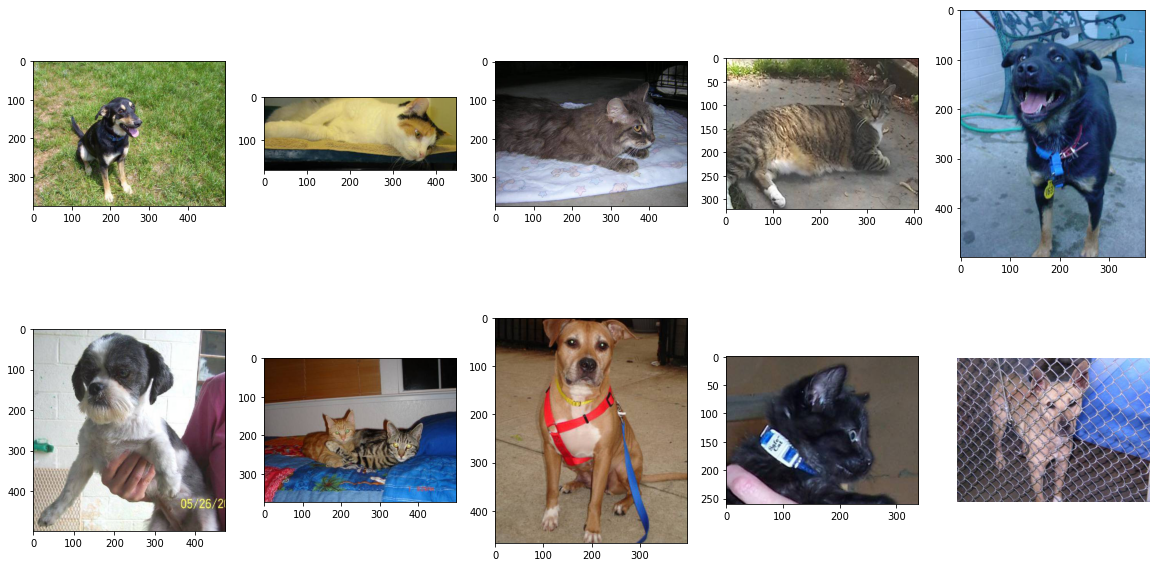

In [32]:
np.random.seed(1313131313)
random_idx = np.random.randint(1,len(train_list),size=10)
print(random_idx)
fig = plt.figure(figsize=(20., 10.))

for i, img_idx in enumerate(random_idx):
    ax = fig.add_subplot(2,5,i+1)
    img = Image.open(train_list[img_idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [33]:
train_list[0].split('/')[-1].split('.')[0]

'cat'

# Data Augmentation

In [34]:
train_transforms =  transforms.Compose([ #these params work well for cats & dogs.:
  # transforms.Resize((224, 224)),
  transforms.RandomResizedCrop(224,scale=(0.9, 1.0)), 
  transforms.RandomHorizontalFlip(),
  transforms.ColorJitter(brightness=.4, hue=.15),
  transforms.ToTensor(),
])

val_transforms = transforms.Compose([
  transforms.Resize((224, 224)),
  # transforms.RandomResizedCrop(224),
  # transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
])

test_transforms = transforms.Compose([   
  transforms.Resize((224, 224)),
  # transforms.RandomResizedCrop(224),
  # transforms.RandomHorizontalFlip(),
  transforms.ToTensor()
])

In [35]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

In [36]:
## Visualization of Image Classification 
import torchvision
def visualize_classification(loader_iter, nrofItems = 9, pad = 0) -> None:

  #Iterate through the data loader
  imgTensor, labels = next(loader_iter)
  labels = labels.tolist()

  # Generate image grid
  grid = torchvision.utils.make_grid(imgTensor[:nrofItems], padding = pad, nrow=nrofItems)

  # Permute the axis as numpy expects image of shape (H x W x C) 
  grid = grid.permute(1, 2, 0)
  
  # Set up plot config
  plt.figure(figsize=(8, 2), dpi=300)
  plt.axis('off')

  # Plot Image Grid
  plt.imshow(grid)
  
  # # Plot the image titles
  # fact = 1 + (nrofItems)/100
  # rng = np.linspace(1/(fact*nrofItems), 1 - 1/(fact*nrofItems) , num = nrofItems)
  # for idx, val in enumerate(rng):
  #   plt.figtext(val, 0.85, labels[idx], fontsize=8)

  # Show the plot
  plt.show()

In [37]:
batch_size = 100 # we will use mini-batch method

In [38]:
train_data = dataset(train_list, transform=train_transforms)
val_data = dataset(val_list, transform=val_transforms)
test_data = dataset(test_list, transform=test_transforms)
visualise_train_dataset = dataset(train_list, transform=train_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=False )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)
vis_train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=False)

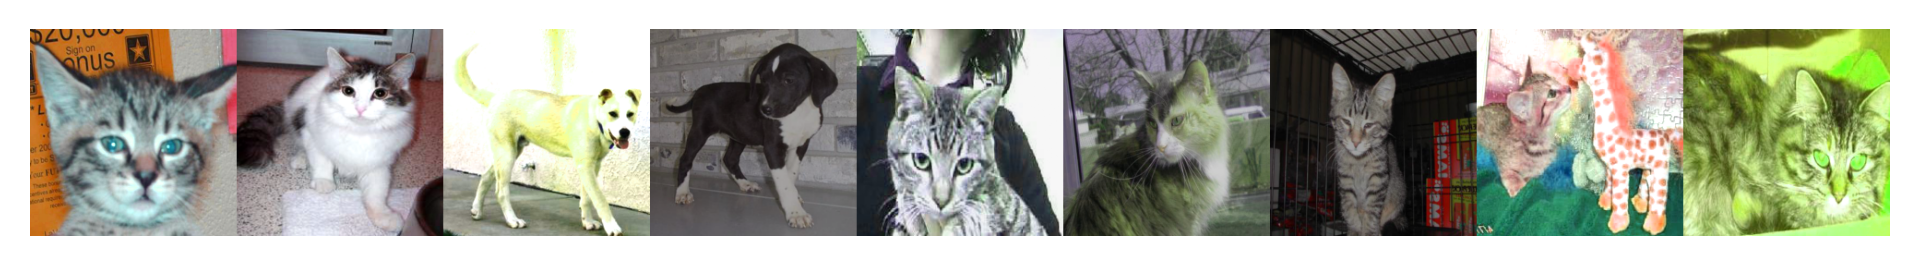

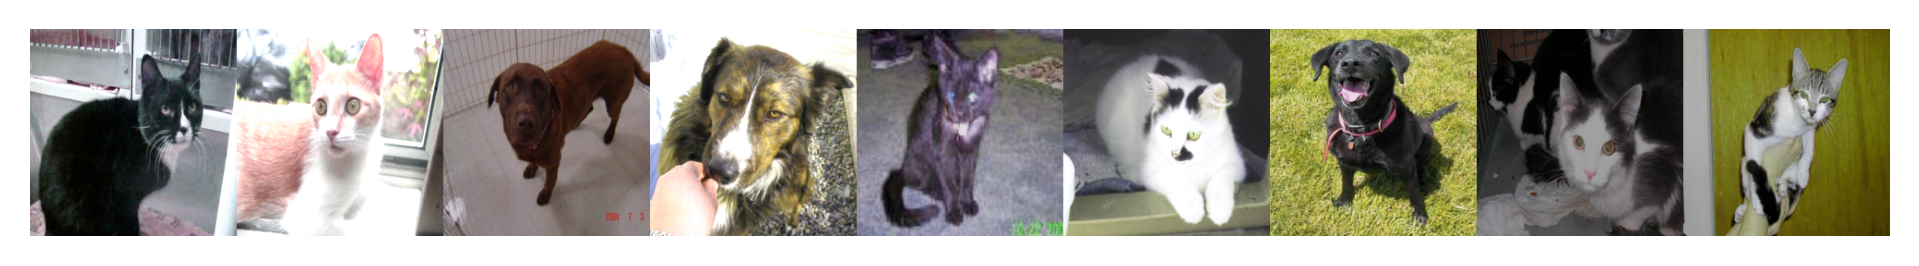

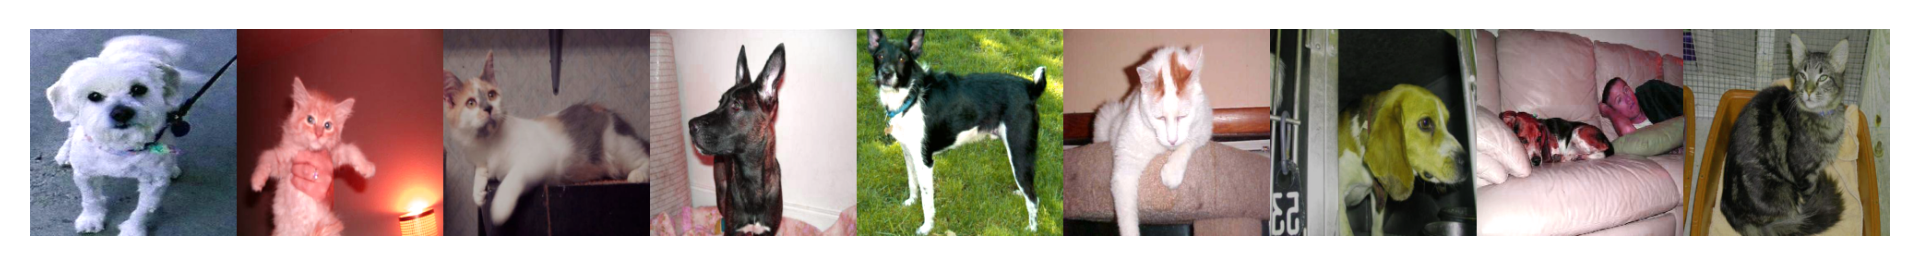

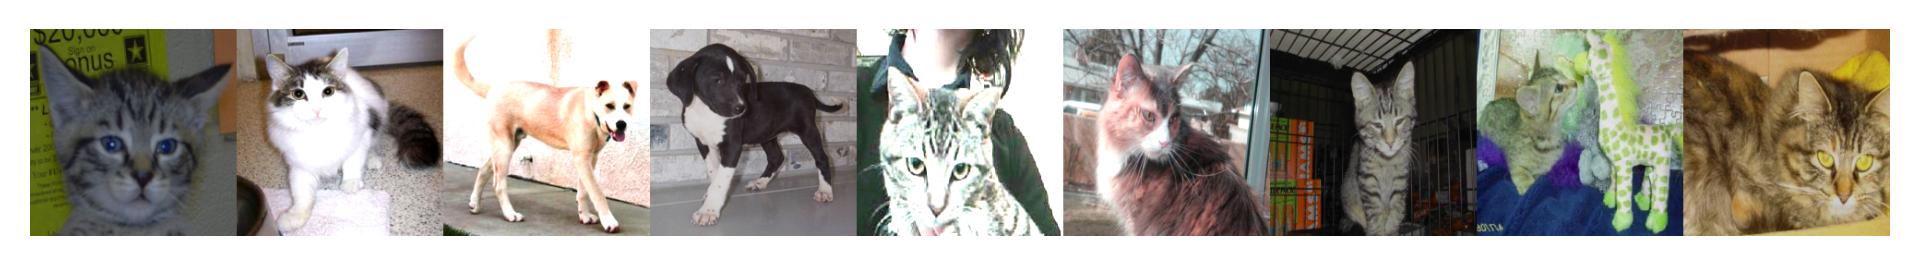

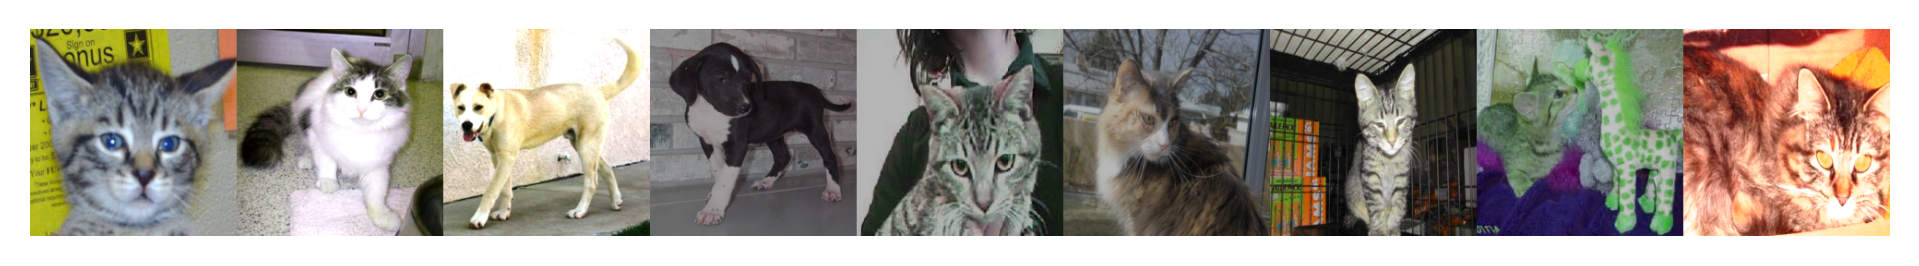

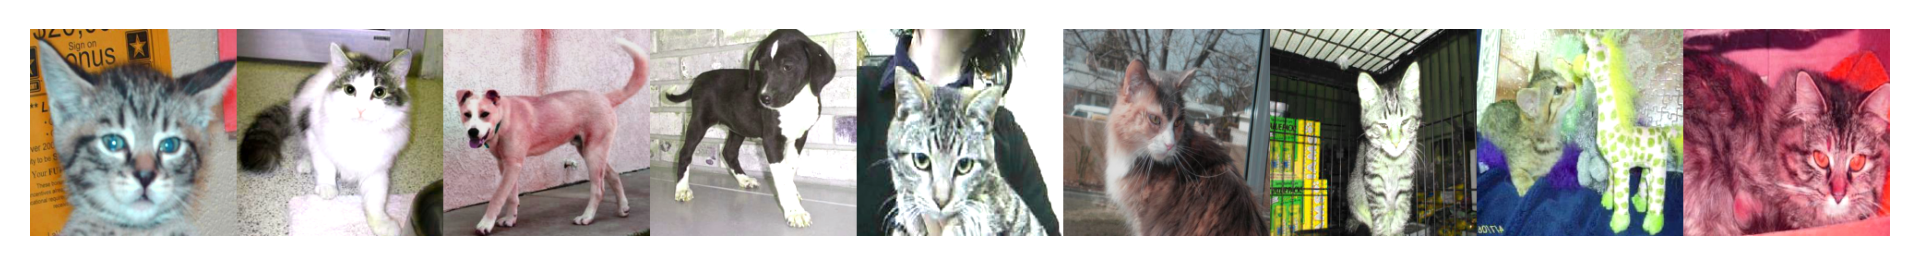

In [39]:
# this cell is here only because the Author apprently didn't understand how Dataset and Dataloaders behave - are they iterable, are they generators? - well they are hybrid. - , and wanted to see what happens
# all but one cell can be commented
# TODO: you don't need a separate loader. each iteration goes from the beginning
# but its interesting that different augmentations get generated.
iterator = iter(vis_train_loader)
visualize_classification(iterator)
visualize_classification(iterator)
visualize_classification(iterator)
visualize_classification(iter(vis_train_loader))
visualize_classification(iter(vis_train_loader))
visualize_classification(iter(vis_train_loader))

In [40]:
print(len(train_data), len(train_loader), len(test_loader))

500 5 50


In [41]:
print(sum(1 for filename in train_data.file_list if 'cat' in filename))
print(sum(1 for filename in train_data.file_list if 'dog' in filename))
print(sum(1 for filename in val_data.file_list if 'cat' in filename))
print(sum(1 for filename in val_data.file_list if 'dog' in filename))
print(sum(1 for filename in test_data.file_list if 'cat' in filename))
print(sum(1 for filename in test_data.file_list if 'dog' in filename))

250
250
2500
2500
2500
2500


In [42]:
#check our images shape
train_data[0][0].shape

torch.Size([3, 224, 224])

In [43]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [44]:
model = model.to(device)
model.train()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [45]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [46]:
def eval_model(loader: torch.utils.data.dataloader.DataLoader, model: nn.Module, description: str="Evaluation:") -> tuple: #[torch.Tensor, torch.Tensor] detailed tuple types only in Python >3.9, colab has 3.8.16
  epoch_accuracy=0
  epoch_loss =0
  with torch.no_grad():
    with tqdm(loader, unit="iteration") as tqdm_wrapped_loader:
      tqdm_wrapped_loader.set_description(description)
      for data, label in tqdm_wrapped_loader:
          data = data.to(device)
          label = label.to(device)

          output = model(data)
          loss = criterion(output,label)


          acc = ((output.argmax(dim=1) == label).float().mean())
          epoch_accuracy += acc/ len(loader)
          epoch_loss += loss/ len(loader)
          tqdm_wrapped_loader.set_postfix(epoch_accuracy=epoch_accuracy, loss=epoch_loss)
  return epoch_accuracy, epoch_loss

In [47]:
epochs = 100 #10
min_val_loss = float('inf')
epochs_since_min_loss = 0
patience = 7
final_scores = {}

for epoch in range(epochs):
    print("\n","="*30,"\n")
    epoch_loss = 0
    epoch_accuracy = 0
    
    with tqdm(train_loader, unit="iteration") as tepoch:
      
      for data, label in tepoch:
          tepoch.set_description(f"Training epoch {epoch}")
          data = data.to(device)
          label = label.to(device)
          
          output = model(data)
          loss = criterion(output, label)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          acc = ((output.argmax(dim=1) == label).float().mean())
          epoch_accuracy += acc/len(train_loader)
          epoch_loss += loss/len(train_loader)
          tepoch.set_postfix(loss=loss.item(), accuracy=100. * epoch_accuracy)
      print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch, epoch_accuracy,epoch_loss))

    
      # with torch.no_grad():
      #     epoch_val_accuracy=0
      #     epoch_val_loss =0
      #     with tqdm(val_loader, unit="iteration") as tqdm_wrapped_valid_loader:
      #       tepoch.set_description(f"Validation after epoch {epoch}")
      #       for data, label in tqdm_wrapped_valid_loader:
      #           data = data.to(device)
      #           label = label.to(device)
                
      #           val_output = model(data)
      #           val_loss = criterion(val_output,label)
                
                
      #           acc = ((val_output.argmax(dim=1) == label).float().mean())
      #           epoch_val_accuracy += acc/ len(val_loader)
      #           epoch_val_loss += val_loss/ len(val_loader)
      #           tqdm_wrapped_valid_loader.set_postfix(epoch_val_accuracy=epoch_val_accuracy, val_loss=val_loss)
    epoch_val_accuracy,epoch_val_loss = eval_model(val_loader, model, f"Validation after epoch {epoch}")
    print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch, epoch_val_accuracy,epoch_val_loss))
    scalar_val_loss = epoch_val_loss.item()
    if scalar_val_loss < min_val_loss:
      min_val_loss = scalar_val_loss 
      epochs_since_min_loss = 0 
      final_scores['epoch']=epoch
      final_scores['epoch_train_accuracy']=epoch_accuracy
      final_scores['epoch_train_loss']=epoch_loss
      final_scores['epoch_val_loss']=epoch_val_loss
      final_scores['epoch_val_accuracy']=epoch_val_accuracy


      print("New best model, min_val_loss:", min_val_loss)


      # with torch.no_grad():
      #     epoch_test_accuracy=0
      #     epoch_test_loss =0
      #     with tqdm(test_loader, unit="iteration") as tqdm_wrapped_test_loader:
      #       tepoch.set_description(f"Test after epoch {epoch}")
      #       for data, label in tqdm_wrapped_test_loader:
      #           data = data.to(device)
      #           label = label.to(device)
                
      #           test_output = model(data)
      #           test_loss = criterion(test_output,label)
                
                
      #           acc = ((test_output.argmax(dim=1) == label).float().mean())
      #           epoch_test_accuracy += acc/ len(test_loader)
      #           epoch_test_loss += test_loss/ len(test_loader)
      #           tqdm_wrapped_test_loader.set_postfix(epoch_test_accuracy=epoch_test_accuracy, test_loss=test_loss)

      # epoch_test_accuracy,epoch_test_loss = eval_model(test_loader, model, f"Test after epoch {epoch}")
      # print('Epoch : {}, test_accuracy : {}, test_loss : {}'.format(epoch, epoch_test_accuracy,epoch_test_loss))



    else:
      epochs_since_min_loss+=1
      print("epochs_since_min_loss",epochs_since_min_loss)
    if epochs_since_min_loss > patience:
      print(f"Early stopping. \n\n Best model scores: {final_scores}")
      break

Training epoch 0: 100%|██████████| 5/5 [00:06<00:00,  1.26s/iteration, accuracy=tensor(43.8000, device='cuda:0'), loss=2.96]


Epoch : 0, train accuracy : 0.43799999356269836, train loss : 4.937938690185547


Validation after epoch 0: 100%|██████████| 50/50 [00:25<00:00,  1.94iteration/s, epoch_accuracy=tensor(0.6038, device='cuda:0'), loss=tensor(2.0248, device='cuda:0')]


Epoch : 0, val_accuracy : 0.6037998795509338, val_loss : 2.024817943572998
New best model, min_val_loss: 2.024817943572998




Training epoch 1: 100%|██████████| 5/5 [00:06<00:00,  1.26s/iteration, accuracy=tensor(56.6000, device='cuda:0'), loss=0.764]


Epoch : 1, train accuracy : 0.5659999847412109, train loss : 1.2449387311935425


Validation after epoch 1: 100%|██████████| 50/50 [00:26<00:00,  1.88iteration/s, epoch_accuracy=tensor(0.5998, device='cuda:0'), loss=tensor(0.6957, device='cuda:0')]


Epoch : 1, val_accuracy : 0.5997999906539917, val_loss : 0.6957204937934875
New best model, min_val_loss: 0.6957204937934875




Training epoch 2: 100%|██████████| 5/5 [00:06<00:00,  1.27s/iteration, accuracy=tensor(56., device='cuda:0'), loss=0.68]


Epoch : 2, train accuracy : 0.5600000023841858, train loss : 0.7028872966766357


Validation after epoch 2: 100%|██████████| 50/50 [00:25<00:00,  1.95iteration/s, epoch_accuracy=tensor(0.5892, device='cuda:0'), loss=tensor(0.6683, device='cuda:0')]


Epoch : 2, val_accuracy : 0.5892001390457153, val_loss : 0.668285071849823
New best model, min_val_loss: 0.668285071849823




Training epoch 3: 100%|██████████| 5/5 [00:06<00:00,  1.28s/iteration, accuracy=tensor(57.8000, device='cuda:0'), loss=0.698]


Epoch : 3, train accuracy : 0.578000009059906, train loss : 0.6831769347190857


Validation after epoch 3: 100%|██████████| 50/50 [00:25<00:00,  1.95iteration/s, epoch_accuracy=tensor(0.5778, device='cuda:0'), loss=tensor(0.6743, device='cuda:0')]


Epoch : 3, val_accuracy : 0.577799916267395, val_loss : 0.6742604970932007
epochs_since_min_loss 1




Training epoch 4: 100%|██████████| 5/5 [00:06<00:00,  1.26s/iteration, accuracy=tensor(59.2000, device='cuda:0'), loss=0.685]


Epoch : 4, train accuracy : 0.5920000076293945, train loss : 0.6616060137748718


Validation after epoch 4: 100%|██████████| 50/50 [00:25<00:00,  1.94iteration/s, epoch_accuracy=tensor(0.6052, device='cuda:0'), loss=tensor(0.6548, device='cuda:0')]


Epoch : 4, val_accuracy : 0.6051998734474182, val_loss : 0.6547693014144897
New best model, min_val_loss: 0.6547693014144897




Training epoch 5: 100%|██████████| 5/5 [00:06<00:00,  1.28s/iteration, accuracy=tensor(59.8000, device='cuda:0'), loss=0.666]


Epoch : 5, train accuracy : 0.5979999899864197, train loss : 0.6769176721572876


Validation after epoch 5: 100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_accuracy=tensor(0.6146, device='cuda:0'), loss=tensor(0.6531, device='cuda:0')]


Epoch : 5, val_accuracy : 0.6145999431610107, val_loss : 0.6530541181564331
New best model, min_val_loss: 0.6530541181564331




Training epoch 6: 100%|██████████| 5/5 [00:06<00:00,  1.27s/iteration, accuracy=tensor(60.6000, device='cuda:0'), loss=0.65]


Epoch : 6, train accuracy : 0.6060000061988831, train loss : 0.6486489176750183


Validation after epoch 6: 100%|██████████| 50/50 [00:27<00:00,  1.85iteration/s, epoch_accuracy=tensor(0.6200, device='cuda:0'), loss=tensor(0.6518, device='cuda:0')]


Epoch : 6, val_accuracy : 0.6200000047683716, val_loss : 0.6518374681472778
New best model, min_val_loss: 0.6518374681472778




Training epoch 7: 100%|██████████| 5/5 [00:06<00:00,  1.27s/iteration, accuracy=tensor(65., device='cuda:0'), loss=0.698]


Epoch : 7, train accuracy : 0.6499999761581421, train loss : 0.6502870321273804


Validation after epoch 7: 100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_accuracy=tensor(0.6138, device='cuda:0'), loss=tensor(0.6647, device='cuda:0')]


Epoch : 7, val_accuracy : 0.6137999892234802, val_loss : 0.6647130846977234
epochs_since_min_loss 1




Training epoch 8: 100%|██████████| 5/5 [00:06<00:00,  1.28s/iteration, accuracy=tensor(60.8000, device='cuda:0'), loss=0.665]


Epoch : 8, train accuracy : 0.6079999804496765, train loss : 0.6547008752822876


Validation after epoch 8: 100%|██████████| 50/50 [00:25<00:00,  1.94iteration/s, epoch_accuracy=tensor(0.6282, device='cuda:0'), loss=tensor(0.6428, device='cuda:0')]


Epoch : 8, val_accuracy : 0.6281999349594116, val_loss : 0.6427664160728455
New best model, min_val_loss: 0.6427664160728455




Training epoch 9: 100%|██████████| 5/5 [00:06<00:00,  1.28s/iteration, accuracy=tensor(62.2000, device='cuda:0'), loss=0.65]


Epoch : 9, train accuracy : 0.621999979019165, train loss : 0.653876543045044


Validation after epoch 9: 100%|██████████| 50/50 [00:25<00:00,  1.95iteration/s, epoch_accuracy=tensor(0.6302, device='cuda:0'), loss=tensor(0.6499, device='cuda:0')]


Epoch : 9, val_accuracy : 0.6301999688148499, val_loss : 0.6498913764953613
epochs_since_min_loss 1




Training epoch 10: 100%|██████████| 5/5 [00:06<00:00,  1.27s/iteration, accuracy=tensor(64.6000, device='cuda:0'), loss=0.66]


Epoch : 10, train accuracy : 0.6460000276565552, train loss : 0.6253888010978699


Validation after epoch 10: 100%|██████████| 50/50 [00:25<00:00,  1.94iteration/s, epoch_accuracy=tensor(0.6358, device='cuda:0'), loss=tensor(0.6547, device='cuda:0')]


Epoch : 10, val_accuracy : 0.6357998847961426, val_loss : 0.6546587347984314
epochs_since_min_loss 2




Training epoch 11: 100%|██████████| 5/5 [00:06<00:00,  1.26s/iteration, accuracy=tensor(66., device='cuda:0'), loss=0.592]


Epoch : 11, train accuracy : 0.6599999666213989, train loss : 0.6230239272117615


Validation after epoch 11: 100%|██████████| 50/50 [00:25<00:00,  1.96iteration/s, epoch_accuracy=tensor(0.6410, device='cuda:0'), loss=tensor(0.6380, device='cuda:0')]


Epoch : 11, val_accuracy : 0.6409999132156372, val_loss : 0.6380214691162109
New best model, min_val_loss: 0.6380214691162109




Training epoch 12: 100%|██████████| 5/5 [00:06<00:00,  1.26s/iteration, accuracy=tensor(63.8000, device='cuda:0'), loss=0.659]


Epoch : 12, train accuracy : 0.637999951839447, train loss : 0.6358473300933838


Validation after epoch 12: 100%|██████████| 50/50 [00:25<00:00,  1.95iteration/s, epoch_accuracy=tensor(0.6196, device='cuda:0'), loss=tensor(0.6509, device='cuda:0')]


Epoch : 12, val_accuracy : 0.6195998191833496, val_loss : 0.6508560180664062
epochs_since_min_loss 1




Training epoch 13: 100%|██████████| 5/5 [00:06<00:00,  1.27s/iteration, accuracy=tensor(66.4000, device='cuda:0'), loss=0.574]


Epoch : 13, train accuracy : 0.6639999747276306, train loss : 0.592434823513031


Validation after epoch 13: 100%|██████████| 50/50 [00:26<00:00,  1.87iteration/s, epoch_accuracy=tensor(0.6528, device='cuda:0'), loss=tensor(0.6525, device='cuda:0')]


Epoch : 13, val_accuracy : 0.6527999043464661, val_loss : 0.6524621844291687
epochs_since_min_loss 2




Training epoch 14: 100%|██████████| 5/5 [00:06<00:00,  1.26s/iteration, accuracy=tensor(65.6000, device='cuda:0'), loss=0.602]


Epoch : 14, train accuracy : 0.656000018119812, train loss : 0.6195569634437561


Validation after epoch 14: 100%|██████████| 50/50 [00:25<00:00,  1.95iteration/s, epoch_accuracy=tensor(0.6424, device='cuda:0'), loss=tensor(0.6351, device='cuda:0')]


Epoch : 14, val_accuracy : 0.6423999071121216, val_loss : 0.6351286172866821
New best model, min_val_loss: 0.6351286172866821




Training epoch 15: 100%|██████████| 5/5 [00:06<00:00,  1.25s/iteration, accuracy=tensor(65.8000, device='cuda:0'), loss=0.614]


Epoch : 15, train accuracy : 0.6579999923706055, train loss : 0.6170637011528015


Validation after epoch 15: 100%|██████████| 50/50 [00:25<00:00,  1.94iteration/s, epoch_accuracy=tensor(0.6326, device='cuda:0'), loss=tensor(0.6414, device='cuda:0')]


Epoch : 15, val_accuracy : 0.6325997710227966, val_loss : 0.6413753032684326
epochs_since_min_loss 1




Training epoch 16: 100%|██████████| 5/5 [00:06<00:00,  1.27s/iteration, accuracy=tensor(64.6000, device='cuda:0'), loss=0.661]


Epoch : 16, train accuracy : 0.6460000276565552, train loss : 0.6233035922050476


Validation after epoch 16: 100%|██████████| 50/50 [00:25<00:00,  1.94iteration/s, epoch_accuracy=tensor(0.6376, device='cuda:0'), loss=tensor(0.6446, device='cuda:0')]


Epoch : 16, val_accuracy : 0.6375998854637146, val_loss : 0.6446157097816467
epochs_since_min_loss 2




Training epoch 17: 100%|██████████| 5/5 [00:06<00:00,  1.26s/iteration, accuracy=tensor(64.8000, device='cuda:0'), loss=0.679]


Epoch : 17, train accuracy : 0.6480000019073486, train loss : 0.6310372948646545


Validation after epoch 17: 100%|██████████| 50/50 [00:25<00:00,  1.94iteration/s, epoch_accuracy=tensor(0.6408, device='cuda:0'), loss=tensor(0.6346, device='cuda:0')]


Epoch : 17, val_accuracy : 0.6407999992370605, val_loss : 0.634568452835083
New best model, min_val_loss: 0.634568452835083




Training epoch 18: 100%|██████████| 5/5 [00:06<00:00,  1.27s/iteration, accuracy=tensor(67.8000, device='cuda:0'), loss=0.608]


Epoch : 18, train accuracy : 0.6780000329017639, train loss : 0.6027511358261108


Validation after epoch 18: 100%|██████████| 50/50 [00:25<00:00,  1.94iteration/s, epoch_accuracy=tensor(0.6364, device='cuda:0'), loss=tensor(0.6473, device='cuda:0')]


Epoch : 18, val_accuracy : 0.6363998651504517, val_loss : 0.6472740173339844
epochs_since_min_loss 1




Training epoch 19: 100%|██████████| 5/5 [00:06<00:00,  1.26s/iteration, accuracy=tensor(69., device='cuda:0'), loss=0.618]


Epoch : 19, train accuracy : 0.6899999976158142, train loss : 0.5997704863548279


Validation after epoch 19: 100%|██████████| 50/50 [00:25<00:00,  1.96iteration/s, epoch_accuracy=tensor(0.6512, device='cuda:0'), loss=tensor(0.6402, device='cuda:0')]


Epoch : 19, val_accuracy : 0.6511998772621155, val_loss : 0.6402111053466797
epochs_since_min_loss 2




Training epoch 20: 100%|██████████| 5/5 [00:06<00:00,  1.26s/iteration, accuracy=tensor(68.8000, device='cuda:0'), loss=0.625]


Epoch : 20, train accuracy : 0.687999963760376, train loss : 0.5974526405334473


Validation after epoch 20: 100%|██████████| 50/50 [00:26<00:00,  1.86iteration/s, epoch_accuracy=tensor(0.6424, device='cuda:0'), loss=tensor(0.6352, device='cuda:0')]


Epoch : 20, val_accuracy : 0.6423998475074768, val_loss : 0.6351681351661682
epochs_since_min_loss 3




Training epoch 21: 100%|██████████| 5/5 [00:06<00:00,  1.26s/iteration, accuracy=tensor(68.0000, device='cuda:0'), loss=0.63]


Epoch : 21, train accuracy : 0.6799999475479126, train loss : 0.5827375650405884


Validation after epoch 21: 100%|██████████| 50/50 [00:25<00:00,  1.95iteration/s, epoch_accuracy=tensor(0.6536, device='cuda:0'), loss=tensor(0.6447, device='cuda:0')]


Epoch : 21, val_accuracy : 0.6535999774932861, val_loss : 0.6446630954742432
epochs_since_min_loss 4




Training epoch 22: 100%|██████████| 5/5 [00:06<00:00,  1.26s/iteration, accuracy=tensor(71.4000, device='cuda:0'), loss=0.553]


Epoch : 22, train accuracy : 0.7139999866485596, train loss : 0.5813001394271851


Validation after epoch 22: 100%|██████████| 50/50 [00:25<00:00,  1.95iteration/s, epoch_accuracy=tensor(0.6486, device='cuda:0'), loss=tensor(0.6329, device='cuda:0')]


Epoch : 22, val_accuracy : 0.6486000418663025, val_loss : 0.6329022645950317
New best model, min_val_loss: 0.6329022645950317




Training epoch 23: 100%|██████████| 5/5 [00:06<00:00,  1.26s/iteration, accuracy=tensor(72.6000, device='cuda:0'), loss=0.622]


Epoch : 23, train accuracy : 0.7259999513626099, train loss : 0.5670217275619507


Validation after epoch 23: 100%|██████████| 50/50 [00:25<00:00,  1.95iteration/s, epoch_accuracy=tensor(0.6488, device='cuda:0'), loss=tensor(0.6351, device='cuda:0')]


Epoch : 23, val_accuracy : 0.6488000750541687, val_loss : 0.6351150870323181
epochs_since_min_loss 1




Training epoch 24: 100%|██████████| 5/5 [00:06<00:00,  1.26s/iteration, accuracy=tensor(70.2000, device='cuda:0'), loss=0.609]


Epoch : 24, train accuracy : 0.7020000219345093, train loss : 0.5611183643341064


Validation after epoch 24: 100%|██████████| 50/50 [00:25<00:00,  1.95iteration/s, epoch_accuracy=tensor(0.6450, device='cuda:0'), loss=tensor(0.6473, device='cuda:0')]


Epoch : 24, val_accuracy : 0.6449999213218689, val_loss : 0.6473259925842285
epochs_since_min_loss 2




Training epoch 25: 100%|██████████| 5/5 [00:06<00:00,  1.26s/iteration, accuracy=tensor(74.6000, device='cuda:0'), loss=0.519]


Epoch : 25, train accuracy : 0.7459999322891235, train loss : 0.5284541845321655


Validation after epoch 25: 100%|██████████| 50/50 [00:25<00:00,  1.94iteration/s, epoch_accuracy=tensor(0.6522, device='cuda:0'), loss=tensor(0.6498, device='cuda:0')]


Epoch : 25, val_accuracy : 0.6521998643875122, val_loss : 0.6497645378112793
epochs_since_min_loss 3




Training epoch 26: 100%|██████████| 5/5 [00:06<00:00,  1.26s/iteration, accuracy=tensor(73.2000, device='cuda:0'), loss=0.609]


Epoch : 26, train accuracy : 0.7319999933242798, train loss : 0.5467765927314758


Validation after epoch 26: 100%|██████████| 50/50 [00:25<00:00,  1.95iteration/s, epoch_accuracy=tensor(0.6522, device='cuda:0'), loss=tensor(0.6631, device='cuda:0')]


Epoch : 26, val_accuracy : 0.6521999835968018, val_loss : 0.6630862355232239
epochs_since_min_loss 4




Training epoch 27: 100%|██████████| 5/5 [00:06<00:00,  1.26s/iteration, accuracy=tensor(72.2000, device='cuda:0'), loss=0.592]


Epoch : 27, train accuracy : 0.722000002861023, train loss : 0.5334264039993286


Validation after epoch 27: 100%|██████████| 50/50 [00:26<00:00,  1.87iteration/s, epoch_accuracy=tensor(0.6422, device='cuda:0'), loss=tensor(0.6802, device='cuda:0')]


Epoch : 27, val_accuracy : 0.6421999335289001, val_loss : 0.680162787437439
epochs_since_min_loss 5




Training epoch 28: 100%|██████████| 5/5 [00:06<00:00,  1.26s/iteration, accuracy=tensor(73.2000, device='cuda:0'), loss=0.503]


Epoch : 28, train accuracy : 0.7319999933242798, train loss : 0.5319798588752747


Validation after epoch 28: 100%|██████████| 50/50 [00:25<00:00,  1.94iteration/s, epoch_accuracy=tensor(0.6504, device='cuda:0'), loss=tensor(0.6453, device='cuda:0')]


Epoch : 28, val_accuracy : 0.6503999829292297, val_loss : 0.6453312635421753
epochs_since_min_loss 6




Training epoch 29: 100%|██████████| 5/5 [00:06<00:00,  1.26s/iteration, accuracy=tensor(75.4000, device='cuda:0'), loss=0.535]


Epoch : 29, train accuracy : 0.7540000677108765, train loss : 0.5108940601348877


Validation after epoch 29: 100%|██████████| 50/50 [00:25<00:00,  1.95iteration/s, epoch_accuracy=tensor(0.6548, device='cuda:0'), loss=tensor(0.6556, device='cuda:0')]


Epoch : 29, val_accuracy : 0.6547999382019043, val_loss : 0.6556057929992676
epochs_since_min_loss 7




Training epoch 30: 100%|██████████| 5/5 [00:06<00:00,  1.26s/iteration, accuracy=tensor(75., device='cuda:0'), loss=0.511]


Epoch : 30, train accuracy : 0.75, train loss : 0.5218753218650818


Validation after epoch 30: 100%|██████████| 50/50 [00:25<00:00,  1.95iteration/s, epoch_accuracy=tensor(0.6470, device='cuda:0'), loss=tensor(0.6619, device='cuda:0')]

Epoch : 30, val_accuracy : 0.6469998955726624, val_loss : 0.6618812084197998
epochs_since_min_loss 8
Early stopping. 

 Best model scores: {'epoch': 22, 'epoch_train_accuracy': tensor(0.7140, device='cuda:0'), 'epoch_train_loss': tensor(0.5813, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6329, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6486, device='cuda:0')}


In [48]:
print(f"Early stopping. \n\n Best model scores: {final_scores}")

Early stopping. 

 Best model scores: {'epoch': 22, 'epoch_train_accuracy': tensor(0.7140, device='cuda:0'), 'epoch_train_loss': tensor(0.5813, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6329, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6486, device='cuda:0')}


In [49]:
dog_probs = []
model.eval()
i=0
with torch.no_grad():b
  for data, fileid in val_loader:
      i+=1
      if i>10:
        break
      data = data.to(device)
      preds = model(data)
      print(preds)
      preds_list = F.softmax(preds, dim=1)[:, 1].tolist() #https://stats.stackexchange.com/questions/542054/why-does-torchvision-models-resnet18-not-use-softmax
      dog_probs += list(zip(list(fileid), preds_list))

IndentationError: ignored

# Future experiments
1000 imgs set; or more intervals; saturate cheap experiments space.

no test
no random crop augmentation
# Results

batch=100, patience=7
============

2000 imgs train set,
transforms.RandomResizedCrop(224,scale=(0.6, 1.0)), 
transforms.RandomHorizontalFlip(),
transforms.ColorJitter(brightness=.4, hue=.15),
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)

Best model scores: 
 {'epoch': 33, 'epoch_train_accuracy': tensor(0.8380, device='cuda:0'), 'epoch_train_loss': tensor(0.3546, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.3896, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8188, device='cuda:0')}

Training epoch 33: 100%|██████████| 20/20 [00:25<00:00,  1.30s/iteration, accuracy=tensor(83.8000, device='cuda:0'), loss=0.395]
Epoch : 33, train accuracy : 0.8380000591278076, train loss : 0.3545871675014496
100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_val_accuracy=tensor(0.8188, device='cuda:0'), val_loss=tensor(0.4697, device='cuda:0')]
Epoch : 33, val_accuracy : 0.8188000321388245, val_loss : 0.3895597457885742
New best model, min_val_loss: 0.3895597457885742



================================================

500 imgs train set,
transforms.RandomResizedCrop(224,scale=(0.6, 1.0)), 
transforms.RandomHorizontalFlip(),
transforms.ColorJitter(brightness=.4, hue=.15),
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)

Best model scores: {'epoch': 39, 'epoch_train_accuracy': tensor(0.7480, device='cuda:0'), 'epoch_train_loss': tensor(0.5132, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5940, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6928, device='cuda:0')}


Training epoch 39: 100%|██████████| 5/5 [00:06<00:00,  1.27s/iteration, accuracy=tensor(74.8000, device='cuda:0'), loss=0.504]
Epoch : 39, train accuracy : 0.7479999661445618, train loss : 0.5132189393043518
100%|██████████| 50/50 [00:30<00:00,  1.65iteration/s, epoch_val_accuracy=tensor(0.6928, device='cuda:0'), val_loss=tensor(0.6708, device='cuda:0')]
Epoch : 39, val_accuracy : 0.6927998661994934, val_loss : 0.5940383076667786
New best model, min_val_loss: 0.5940383076667786
100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_test_accuracy=tensor(0.6874, device='cuda:0'), test_loss=tensor(0.6752, device='cuda:0')]
Epoch : 39, test_accuracy : 0.6873999238014221, test_loss : 0.5957822799682617

================================================

500 imgs train set,
no transforms (only totensor)
fails with wrong shapes

================================================

500 imgs train set, only 224 resize
 transforms.Resize((224, 224)),


 Best model scores: {'epoch': 2, 'epoch_train_accuracy': tensor(0.6660, device='cuda:0'), 'epoch_train_loss': tensor(0.6178, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6951, device='cuda:0'), 'epoch_val_accuracy': tensor(0.5774, device='cuda:0')}


 Training epoch 2: 100%|██████████| 5/5 [00:03<00:00,  1.28iteration/s, accuracy=tensor(66.6000, device='cuda:0'), loss=0.627]
Epoch : 2, train accuracy : 0.6660000085830688, train loss : 0.6177714467048645
100%|██████████| 50/50 [00:27<00:00,  1.85iteration/s, epoch_val_accuracy=tensor(0.5774, device='cuda:0'), val_loss=tensor(0.7848, device='cuda:0')]
Epoch : 2, val_accuracy : 0.5773999691009521, val_loss : 0.6951212882995605
New best model, min_val_loss: 0.6951212882995605
100%|██████████| 50/50 [00:25<00:00,  1.95iteration/s, epoch_test_accuracy=tensor(0.5704, device='cuda:0'), test_loss=tensor(0.7834, device='cuda:0')]
Epoch : 2, test_accuracy : 0.5703999996185303, test_loss : 0.6962302327156067

note: patience in my implementation (> patience) means 8 more epochs get executed.








========================================


full train set


Training epoch 40: 100%|██████████| 150/150 [03:28<00:00,  1.39s/iteration, accuracy=tensor(96.8067, device='cuda:0'), loss=0.0306]
Epoch : 40, train accuracy : 0.9680668115615845, train loss : 0.07920999079942703
100%|██████████| 50/50 [00:30<00:00,  1.65iteration/s, epoch_val_accuracy=tensor(0.9506, device='cuda:0'), val_loss=tensor(0.1377, device='cuda:0')]
Epoch : 40, val_accuracy : 0.9506001472473145, val_loss : 0.12937913835048676
New best model, min_val_loss: 0.12937913835048676
100%|██████████| 50/50 [00:30<00:00,  1.66iteration/s, epoch_test_accuracy=tensor(0.9522, device='cuda:0'), test_loss=tensor(0.1373, device='cuda:0')]
Epoch : 40, test_accuracy : 0.9522001147270203, test_loss : 0.12997546792030334

 Best model scores: {'epoch': 40, 'epoch_train_accuracy': tensor(0.9681, device='cuda:0'), 'epoch_train_loss': tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.1294, device='cuda:0'), 'epoch_val_accuracy': tensor(0.9506, device='cuda:0')}



 ============================== 

 4000 imgs
 

Training epoch 56: 100%|██████████| 40/40 [00:50<00:00,  1.26s/iteration, accuracy=tensor(95.7750, device='cuda:0'), loss=0.112]
Epoch : 56, train accuracy : 0.9577500224113464, train loss : 0.10647499561309814
Validation after epoch 56: 100%|██████████| 50/50 [00:25<00:00,  1.94iteration/s, epoch_accuracy=tensor(0.8970, device='cuda:0'), loss=tensor(0.2677, device='cuda:0')]Epoch : 56, val_accuracy : 0.8970000147819519, val_loss : 0.26771894097328186
epochs_since_min_loss 8
Early stopping. 

 Best model scores: {'epoch': 48, 'epoch_train_accuracy': tensor(0.9498, device='cuda:0'), 'epoch_train_loss': tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.2475, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8988, device='cuda:0')}


  ============================== 
1000 imgs
Training epoch 46: 100%|██████████| 10/10 [00:12<00:00,  1.25s/iteration, accuracy=tensor(82.7000, device='cuda:0'), loss=0.423]
Epoch : 46, train accuracy : 0.8270000219345093, train loss : 0.3939513862133026
Validation after epoch 46: 100%|██████████| 50/50 [00:26<00:00,  1.92iteration/s, epoch_accuracy=tensor(0.7390, device='cuda:0'), loss=tensor(0.5494, device='cuda:0')]Epoch : 46, val_accuracy : 0.7390000224113464, val_loss : 0.5493948459625244
epochs_since_min_loss 8
Early stopping. 

 Best model scores: {'epoch': 38, 'epoch_train_accuracy': tensor(0.7650, device='cuda:0'), 'epoch_train_loss': tensor(0.4642, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5249, device='cuda:0'), 'epoch_val_accuracy': tensor(0.7464, device='cuda:0')}

[29]
0s
print(f"Early stopping. \n\n Best model scores: {final_scores}")
Early stopping. 

=============================================

300 train imgs


 Best model scores: {'epoch': 36, 'epoch_train_accuracy': tensor(0.7300, device='cuda:0'), 'epoch_train_loss': tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6209, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6694, device='cuda:0')}


 Training epoch 36: 100%|██████████| 3/3 [00:03<00:00,  1.25s/iteration, accuracy=tensor(73., device='cuda:0'), loss=0.505]
Epoch : 36, train accuracy : 0.7300000190734863, train loss : 0.5214951038360596
Validation after epoch 36: 100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_accuracy=tensor(0.6694, device='cuda:0'), loss=tensor(0.6209, device='cuda:0')]
Epoch : 36, val_accuracy : 0.6693997979164124, val_loss : 0.6209338903427124
New best model, min_val_loss: 0.6209338903427124



===================================

100 imgs train



 Best model scores: {'epoch': 26, 'epoch_train_accuracy': tensor(0.6100, device='cuda:0'), 'epoch_train_loss': tensor(0.6548, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6606, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6008, device='cuda:0')}










 ========================


 1000 imgs train 
 no random crop


 Training epoch 11: 100%|██████████| 10/10 [00:13<00:00,  1.32s/iteration, accuracy=tensor(66.1000, device='cuda:0'), loss=0.598]
Epoch : 11, train accuracy : 0.6610000133514404, train loss : 0.6124292612075806
Validation after epoch 11: 100%|██████████| 50/50 [00:28<00:00,  1.78iteration/s, epoch_accuracy=tensor(0.6646, device='cuda:0'), loss=tensor(0.6104, device='cuda:0')]
Epoch : 11, val_accuracy : 0.6645999550819397, val_loss : 0.6103843450546265
New best model, min_val_loss: 0.6103843450546265


=======

4000 imgs no random crop

Best model scores: {'epoch': 21, 'epoch_train_accuracy': tensor(0.8915, device='cuda:0'), 'epoch_train_loss': tensor(0.2574, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.4274, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8212, device='cuda:0')}



=======

4000 imgs random crop (0.9, 1.0)



 Best model scores: {'epoch': 38, 'epoch_train_accuracy': tensor(0.9482, device='cuda:0'), 'epoch_train_loss': tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.3618, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8702, device='cuda:0')}


 =============

 100 (0.9,1.0)


 
 Best model scores: {'epoch': 18, 'epoch_train_accuracy': tensor(0.6400, device='cuda:0'), 'epoch_train_loss': tensor(0.6298, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6644, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6080, device='cuda:0')}

 99.9% sure it was actually 100 samples.


 ==================================

300 (0.9,1.0)
Best model scores: {'epoch': 13, 'epoch_train_accuracy': tensor(0.6600, device='cuda:0'), 'epoch_train_loss': tensor(0.6104, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6303, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6474, device='cuda:0')}

==================================


1000 (0.9, 1.0)

 Best model scores: {'epoch': 31, 'epoch_train_accuracy': tensor(0.7830, device='cuda:0'), 'epoch_train_loss': tensor(0.4721, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5570, device='cuda:0'), 'epoch_val_accuracy': tensor(0.7226, device='cuda:0')}


 =========

2000 0.9-1.0

  Best model scores: {'epoch': 20, 'epoch_train_accuracy': tensor(0.7770, device='cuda:0'), 'epoch_train_loss': tensor(0.4572, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5028, device='cuda:0'), 'epoch_val_accuracy': tensor(0.7600, device='cuda:0')}

==========

1000 0.9-1.0

 Best model scores: {'epoch': 22, 'epoch_train_accuracy': tensor(0.7140, device='cuda:0'), 'epoch_train_loss': tensor(0.5813, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6329, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6486, device='cuda:0')}